Library to track time

In [ ]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.4 MB/s 


In [ ]:
%load_ext autotime

time: 472 µs (started: 2022-08-23 21:25:19 +00:00)


Divide and Concur

In [ ]:
from math import sqrt, floor
import numpy as np

def naive_sharding(ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """
    
    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.mat(np.zeros((k,n)))

    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m/k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shards)
    # Sum columns of shards, get means; these columnar means are centroids
    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids

def _get_mean(sums, step):
    """
    Vectorizable ufunc for getting means of summed shard columns.
    
    Parameters
    ----------
    sums : float
        The summed shard columns.
    step : int
        The number of instances per shard.
    Returns
    -------
    sums/step (means) : numpy array
        The means of the shard columns.
    """

    return sums/step

time: 5.51 ms (started: 2022-08-23 21:25:19 +00:00)


Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

time: 1.85 s (started: 2022-08-23 21:25:24 +00:00)


Data load

In [ ]:
df = pd.read_csv('https://github.com/sumit07041997/Thesis/blob/425c89067f1b5f3317375526aae877ff5795a868/qsar-biodeg.csv?raw=true')

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V33,V34,V35,V36,V37,V38,V39,V40,V41,Class
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,2
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,2
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,2
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,2
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,2


time: 898 ms (started: 2022-08-23 21:25:44 +00:00)


In [ ]:
print(df.isnull().values.any())

False
time: 5.03 ms (started: 2022-08-23 21:25:55 +00:00)


Number of classes and it's count

In [ ]:
lable = df['Class'].copy()
data = df.drop('Class',axis=1)

lable.value_counts()

1    699
2    356
Name: Class, dtype: int64

time: 9.8 ms (started: 2022-08-23 21:26:30 +00:00)


Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data= scaler.fit_transform(data)

time: 9.53 ms (started: 2022-08-23 21:26:36 +00:00)


Elbow Method

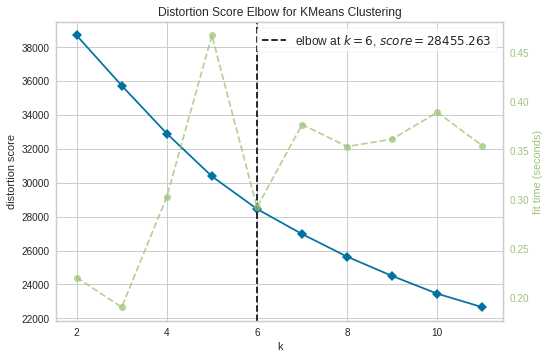

time: 3.97 s (started: 2022-08-23 21:26:38 +00:00)


In [ ]:
from yellowbrick.cluster import KElbowVisualizer
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='distortion'
)
visualizer.fit(data)        
visualizer.show() 

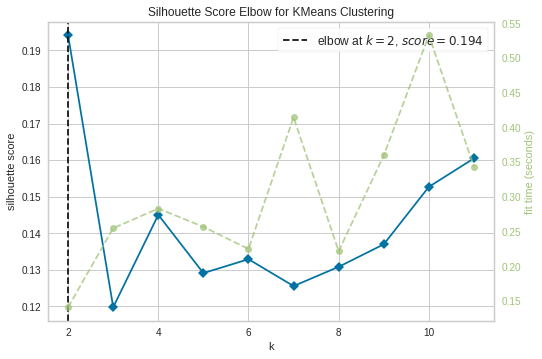

time: 3.63 s (started: 2022-08-23 21:26:42 +00:00)


In [ ]:
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='silhouette')
visualizer.fit(data) 
visualizer.show() 


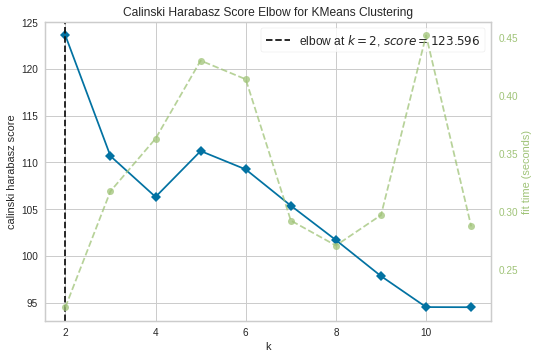

time: 3.67 s (started: 2022-08-23 21:26:50 +00:00)


In [ ]:
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='calinski_harabasz')
visualizer.fit(data) 
visualizer.show()

Time comparison on K-means++, random and divide

In [ ]:
kmeans = KMeans(n_clusters=2,init='random', random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  10
time: 73.9 ms (started: 2022-08-23 21:26:59 +00:00)


In [ ]:
kmeans = KMeans(n_clusters=2,init='k-means++', random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  13
time: 114 ms (started: 2022-08-23 21:27:01 +00:00)


In [ ]:
kmeans = KMeans(n_clusters=2,init=naive_sharding(data,2), random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  11
time: 17.1 ms (started: 2022-08-23 21:27:03 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


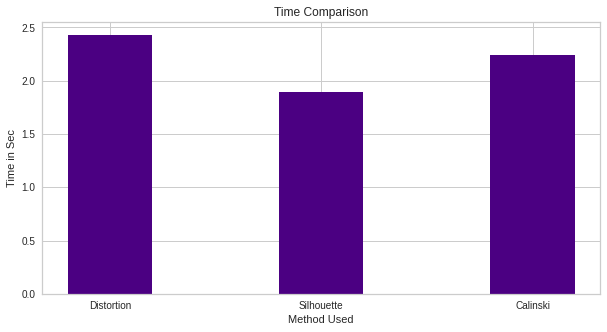

time: 126 ms (started: 2022-08-23 21:27:05 +00:00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 

method = ['Distortion','Silhouette','Calinski']
time = [2.43,1.89,2.24]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(method, time, color ='indigo',
        width = 0.4)
 
plt.xlabel("Method Used")
plt.ylabel("Time in Sec")
plt.title("Time Comparison")
plt.show()